In [1]:
# Import the necessary libraries
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from glob import glob

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as densenet_preprocessing
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf


Classes: ['drive', 'legglance-flick', 'pullshot', 'sweep']


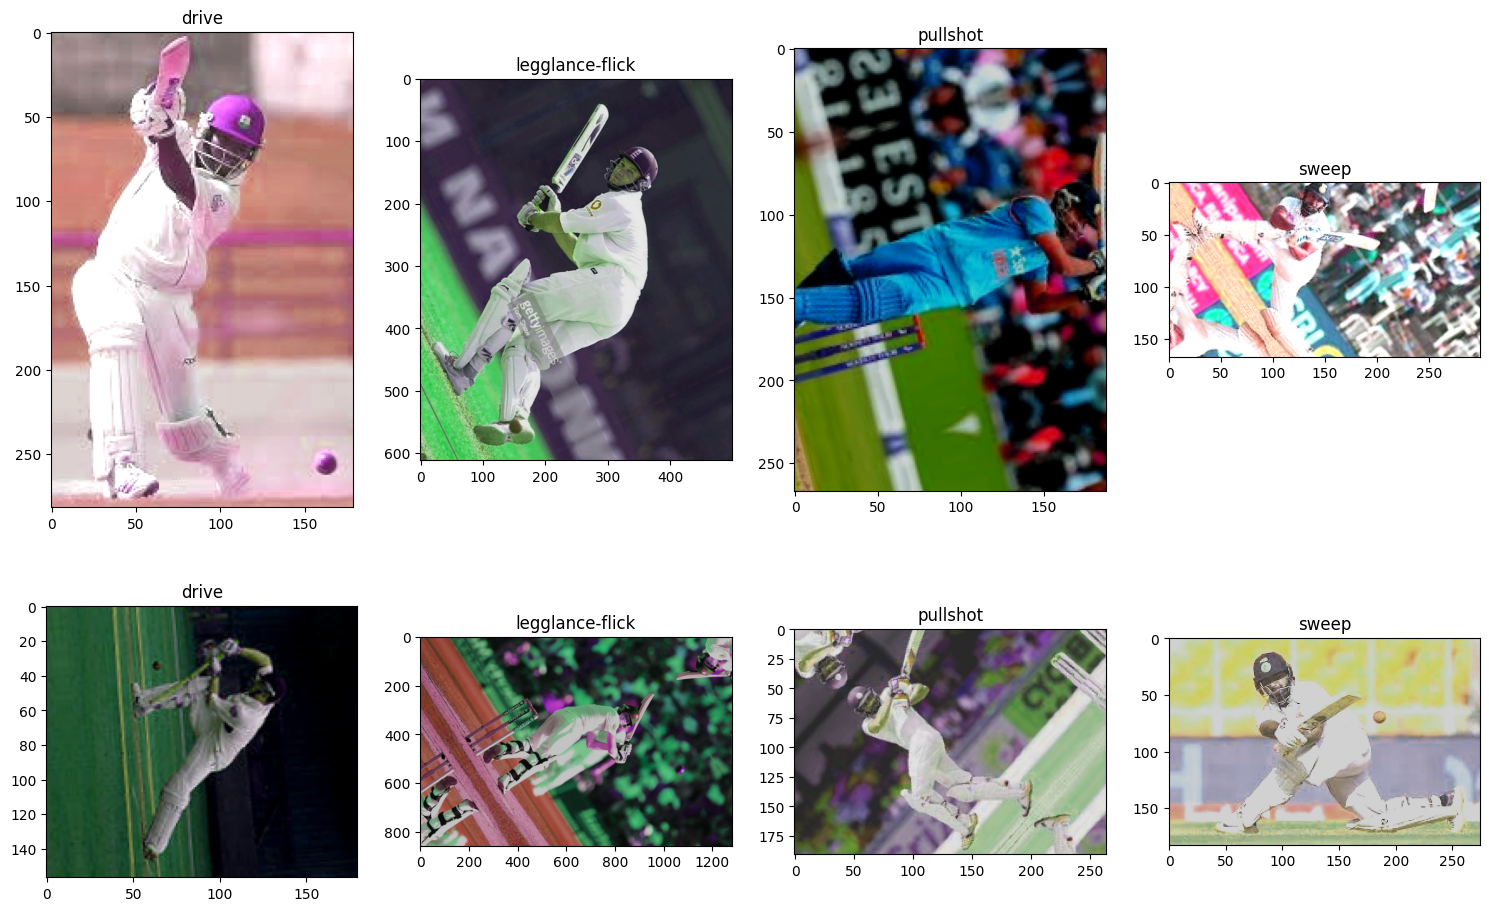

In [2]:
# Define the dataset directory
data_dir = r'G:\projects\cricket shot detection\archive\data'

# List the class names
class_names = os.listdir(data_dir)
print("Classes:", class_names)

# Function to visualize images from the dataset
def visualize_images(image_paths: List[str]):
    max_rows = 2
    max_cols = 4
    fig, axs = plt.subplots(max_rows, max_cols, figsize=(15, 10))
    idx = 0
    for col in range(max_cols):
        for row in range(max_rows):
            if idx < len(image_paths):
                img = cv2.imread(image_paths[idx])
                image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                class_name = image_paths[idx].split(os.path.sep)[-2]
                axs[row, col].imshow(image)
                axs[row, col].set_title(class_name)
            else:
                axs[row, col].axis('off')
            idx += 1
    plt.tight_layout()
    plt.show()

# Sample random images from each class
image_paths = []
for class_name in class_names:
    class_folder = os.path.join(data_dir, class_name)
    all_images = glob(class_folder + '/*.png')
    if len(all_images) >= 2:
        paths = random.sample(all_images, k=2)
        image_paths.extend(paths)

visualize_images(image_paths)


Class distribution:
 label
pullshot           1228
drive              1173
sweep              1100
legglance-flick    1085
Name: count, dtype: int64


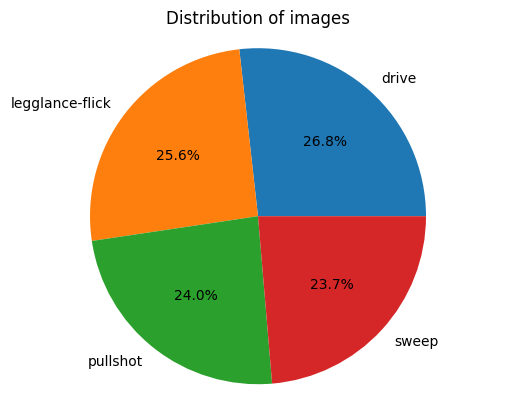

In [3]:
# Create dataframe with image paths and labels
image_paths, class_labels = [], []
for class_name in class_names:
    paths = glob(os.path.join(data_dir, class_name) + '/' + "*.png")
    image_paths.extend(paths)
    class_labels.extend([class_name]*len(paths))

df = pd.DataFrame(data={'image_path': image_paths, 'label': class_labels})

# Display class distribution
print("Class distribution:\n", df['label'].value_counts())

# Pie chart of distribution
labels = df['label'].unique()
sizes = df['label'].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
ax1.set_title("Distribution of images")
plt.show()


In [4]:
# Split data into train, validation, and test sets
X = df
y = df[['label']]

# Train, validation, test split
df_train, df_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.30, random_state=40)
df_val, df_test, y_val, y_test = train_test_split(df_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=40)


In [5]:
# Split data into train, validation, and test sets
X = df
y = df[['label']]

# Train, validation, test split
df_train, df_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.30, random_state=40)
df_val, df_test, y_val, y_test = train_test_split(df_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=40)


In [6]:
# Set up image data generators
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, preprocessing_function=densenet_preprocessing)
val_gen = ImageDataGenerator(preprocessing_function=densenet_preprocessing)
test_gen = ImageDataGenerator(preprocessing_function=densenet_preprocessing)

# Initialize generators
train_generator = train_gen.flow_from_dataframe(df_train, x_col="image_path", y_col="label",
                                                target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                                class_mode='categorical', shuffle=True, seed=42)
valid_generator = val_gen.flow_from_dataframe(df_val, x_col="image_path", y_col="label",
                                              target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                              class_mode='categorical', shuffle=True, seed=42)
test_generator = test_gen.flow_from_dataframe(df_test, x_col="image_path", y_col="label",
                                              target_size=IMG_SIZE, batch_size=1,
                                              class_mode='categorical', shuffle=False)


Found 3210 validated image filenames belonging to 4 classes.
Found 688 validated image filenames belonging to 4 classes.
Found 688 validated image filenames belonging to 4 classes.


In [7]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define and compile DenseNet model with a learning rate of 0.001
base_model = DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze the base model layers

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout layer with 30% dropout rate
output = Dense(len(class_names), activation='softmax')(x)  # Ensure 'class_names' is defined

# Full model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])  # Set learning rate to 0.001


In [8]:
# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=10)

# Custom callback for detailed epoch logging
class CustomLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(f"\nEpoch {epoch+1}:")
        print(f" - Accuracy: {logs.get('accuracy'):.4f}, Validation Accuracy: {logs.get('val_accuracy'):.4f}")
        print(f" - Loss: {logs.get('loss'):.4f}, Validation Loss: {logs.get('val_loss'):.4f}")
        print(f" - Current Learning Rate: {current_lr:.8f}")

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, CustomLoggingCallback()]
)


Epoch 1/10


101/101 [==============================] - ETA: 0s - loss: 1.0827 - accuracy: 0.6150
Epoch 1:
 - Accuracy: 0.6150, Validation Accuracy: 0.8779
 - Loss: 1.0827, Validation Loss: 0.4348
 - Current Learning Rate: 0.00100000
101/101 [==============================] - 119s 1s/step - loss: 1.0827 - accuracy: 0.6150 - val_loss: 0.4348 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 2/10
101/101 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.8399
Epoch 2:
 - Accuracy: 0.8399, Validation Accuracy: 0.9070
 - Loss: 0.4462, Validation Loss: 0.3073
 - Current Learning Rate: 0.00100000
101/101 [==============================] - 111s 1s/step - loss: 0.4462 - accuracy: 0.8399 - val_loss: 0.3073 - val_accuracy: 0.9070 - lr: 0.0010
Epoch 3/10
101/101 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.8928
Epoch 3:
 - Accuracy: 0.8928, Validation Accuracy: 0.9331
 - Loss: 0.2992, Validation Loss: 0.2464
 - Current Learning Rate: 0.00100000
101/101 [===

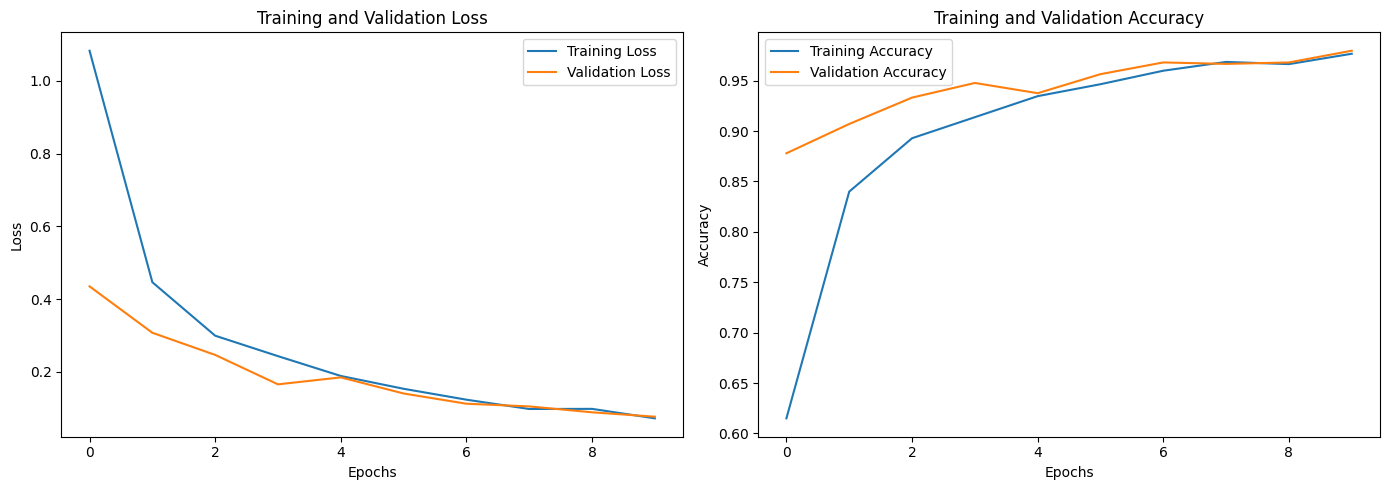

In [9]:
# Function to plot training history
def plot_training(hist):
    plt.figure(figsize=(14, 5))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.show()

# Plot training results
plot_training(history)
